# Hillary Clinton és Donald Trump tweetjeinek elemzése

A jelen notebook a Budapesti Műszaki és Gazdaságtudományi Egyetem, Automatizálási és Alkalmazott Informatikai tanszék Üzleti Intelligencia (BMEVIAUMA02) tárgyának Adatbányászat c. előadásához készült.

A notebook készítője: Ács Judit

## Hogyan tudom otthon futtatni?

A demó telepítése Linux rendszereken a következő lépésekből áll:
1. pip-pel telepíthető csomagok: jupyter, pandas, matplotlib, nltk, wordcloud
2. python interpreterből (python parancs) el kell indítani az NLTK downloadert:


    import nltk
    nltk.download()
    
és letölteni a punkt, illetve a stopwords korpuszokat.

Az adat itt érhető el regisztráció után: https://www.kaggle.com/semioniy/predictemall/downloads/predictemall.zip

Elvileg Windows és OSX rendszereken is ugyanígy telepíthető minden, de ezeket nem teszteltem.

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import nltk
from wordcloud import WordCloud, STOPWORDS

# tegyük szebbé a grafikonokat
matplotlib.style.use('ggplot')
matplotlib.pyplot.rcParams['figure.figsize'] = (25, 13)
matplotlib.pyplot.rcParams['font.family'] = 'sans-serif'
matplotlib.pyplot.rcParams['font.size'] = 20

### Az adatok betöltése

In [2]:
df = pd.read_csv('tweets.csv', parse_dates=['time'])

### Eldobjuk a nem használt oszlopokat 

In [3]:
kept_columns = ['text', 'is_retweet', 'original_author', 'time', 'retweet_count', 'favorite_count', 'handle']
df = df[kept_columns]
df.head(2)

text is_retweet  \
0  The question in this election: Who can put the...      False   
1  Last night, Donald Trump said not paying taxes...       True   

  original_author                time  retweet_count  favorite_count  \
0             NaN 2016-09-28 00:22:34            218             651   
1        timkaine 2016-09-27 23:45:00           2445            5308   

           handle  
0  HillaryClinton  
1  HillaryClinton

## Rövidítsük a jelöltek nevét

In [4]:
df['author'] = "Trump"
df.loc[df['handle'].str.contains("Hill"), "author"] = "Clinton"

## Tweetek időbeli eloszlása 

### Havonta

In [5]:
df.groupby(by=[df.time.dt.year, df.time.dt.month]).count()

text  is_retweet  original_author  time  retweet_count  \
time time                                                           
2016 1      438         438               12   438            438   
     2      494         494               22   494            494   
     3      441         441               21   441            441   
     4      489         489               47   489            489   
     5      710         710               58   710            710   
     6      824         824              107   824            824   
     7     1296        1296              171  1296           1296   
     8      802         802              127   802            802   
     9      950         950              157   950            950   

           favorite_count  handle  author  
time time                                  
2016 1                438     438     438  
     2                494     494     494  
     3                441     441     441  
     4                489     489     489  
     5                710     710     710  
     6                824     824     824  
     7               1296    1296    1296  
     8                802     802     802  
     9                950     950     950

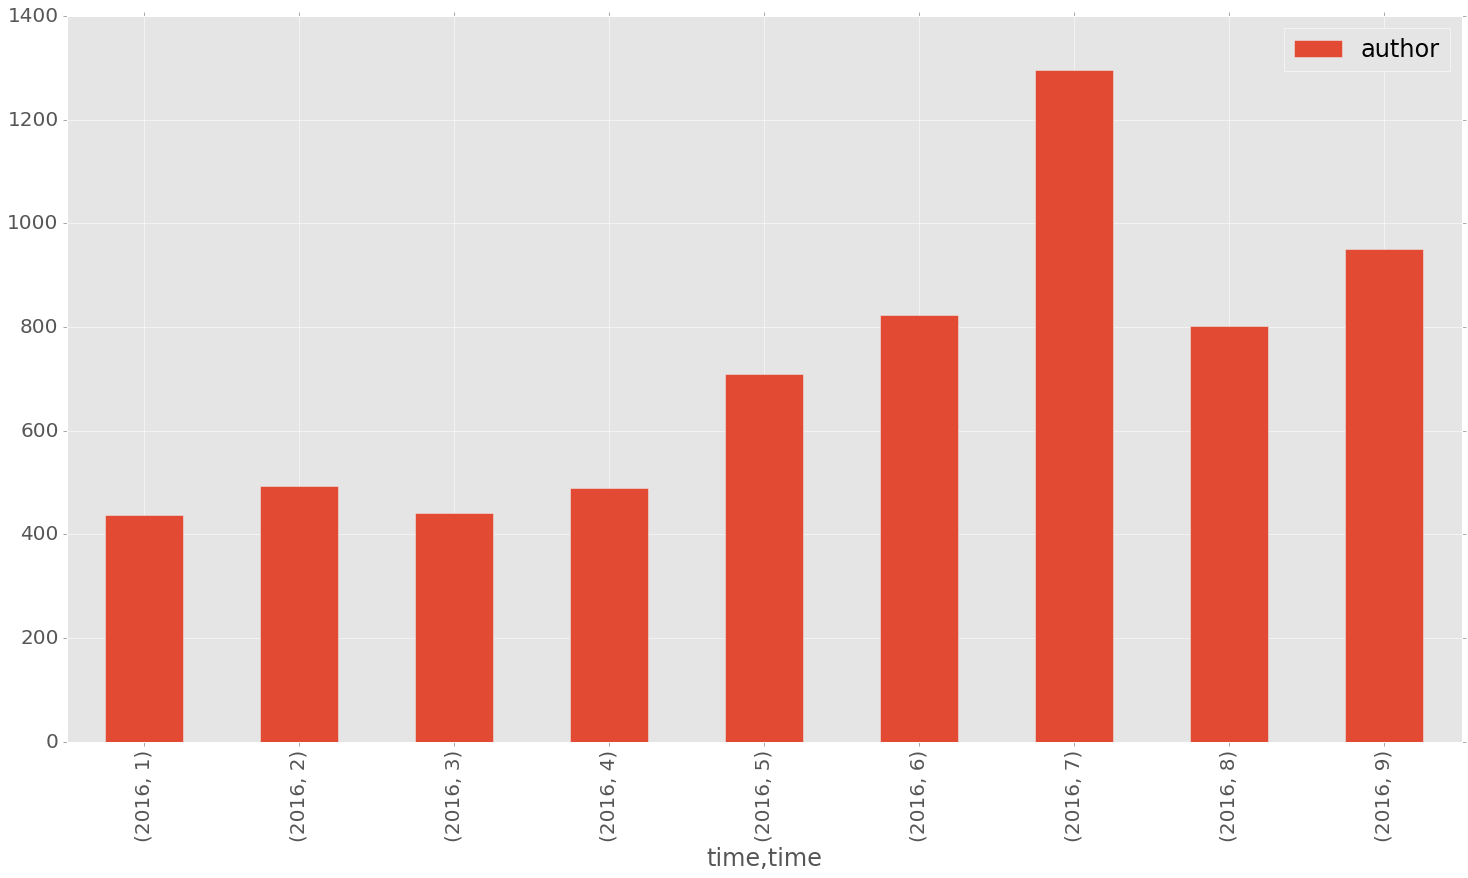

In [6]:
df.groupby(by=[df.time.dt.year, df.time.dt.month]).count().plot(y='author', kind='bar')

## A jelöltek között hogy oszlik ez el

Egy kis Dataframe magic, majd laboron visszatérünk rá

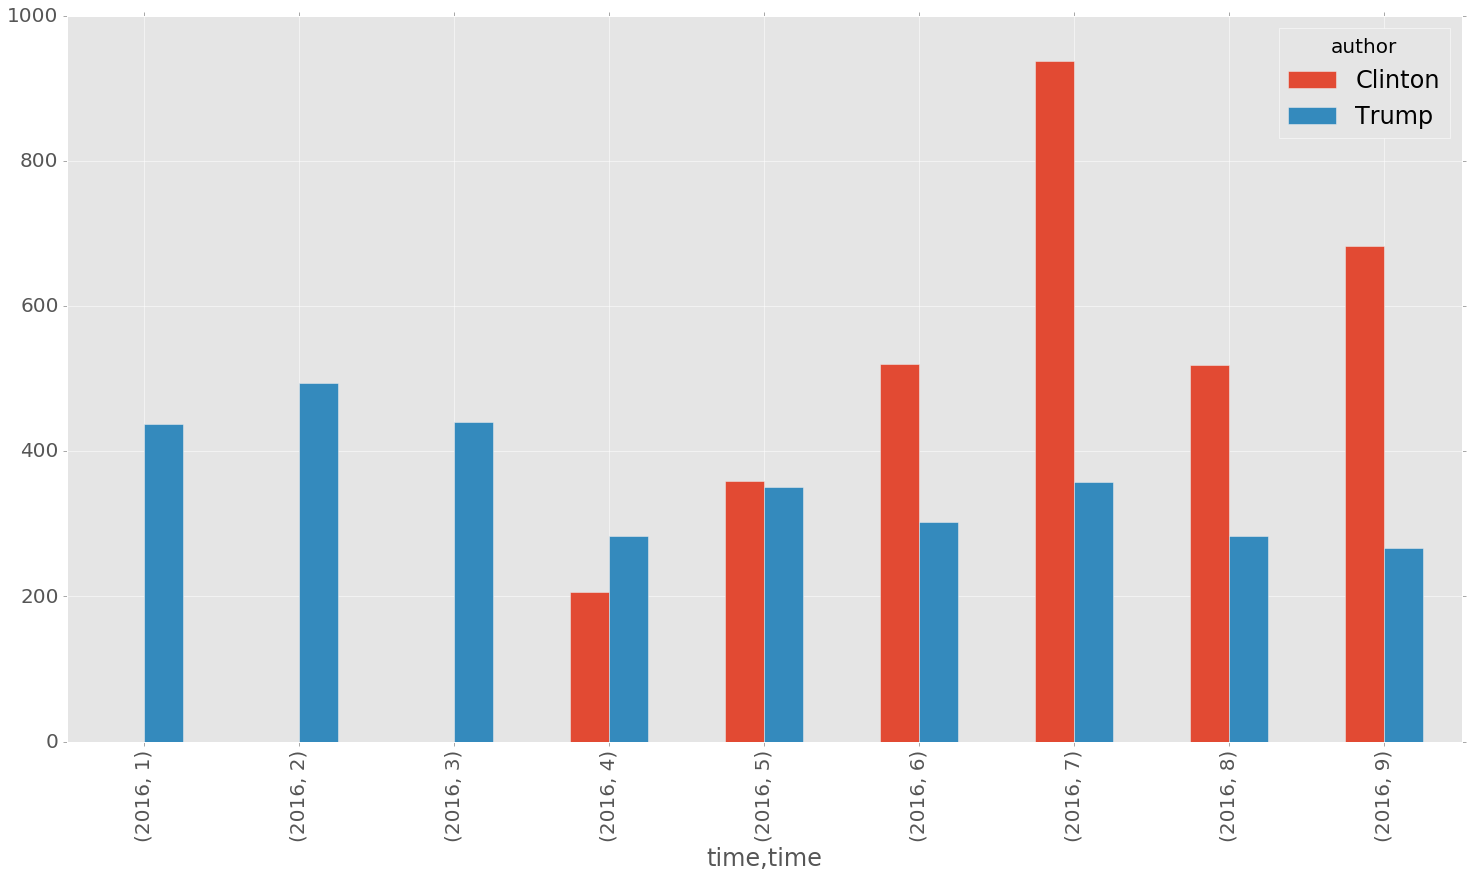

In [7]:
df.groupby(by=[df.author, df.time.dt.year, df.time.dt.month]).count().unstack('author')['handle'].plot(kind='bar', y=['Clinton', 'Trump'])

## Óránként hányat tweetelnek?

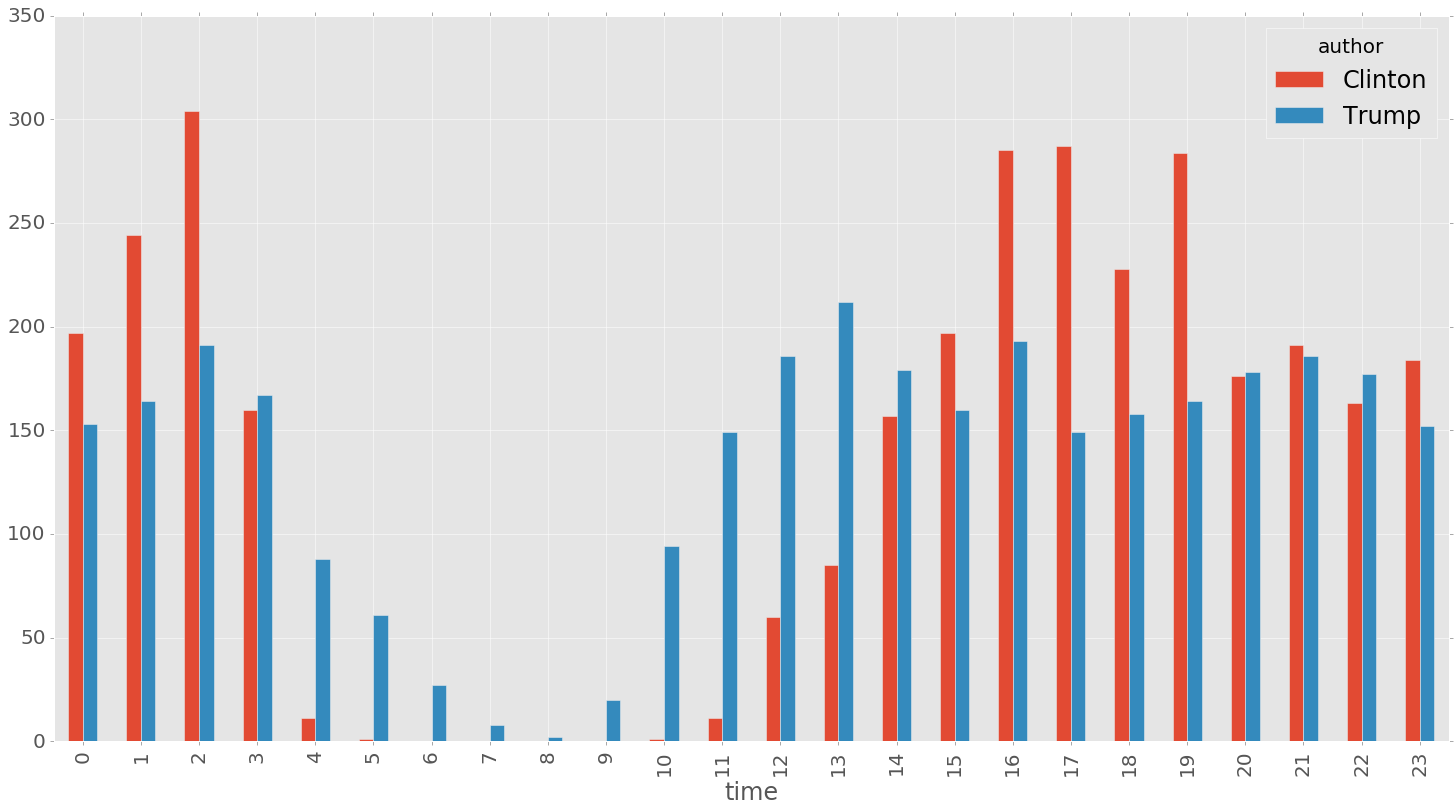

In [8]:
df.groupby(by=[df.author, df.time.dt.hour]).count().unstack('author')['handle'].plot(kind='bar', y=['Clinton', 'Trump'])

## Retweet count

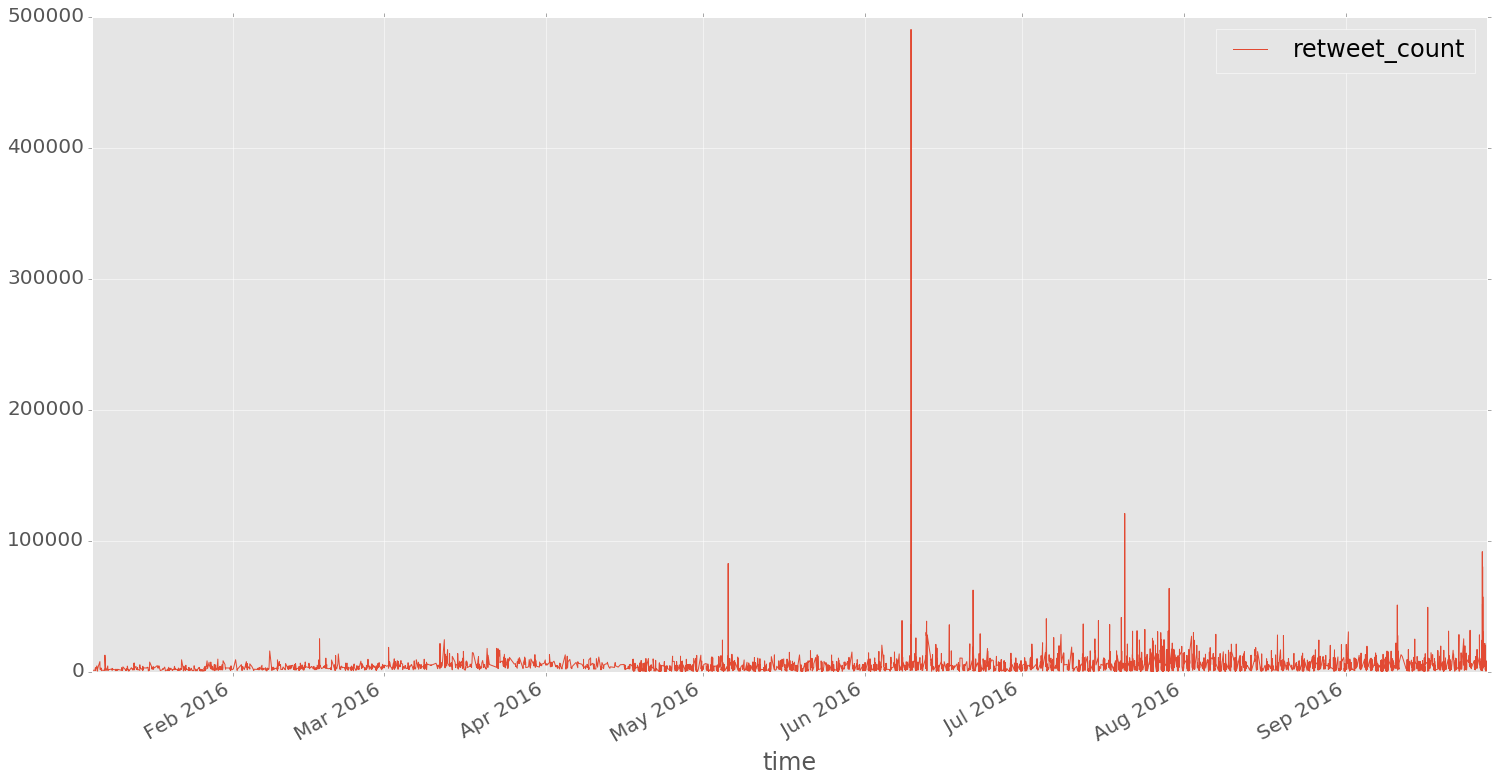

In [9]:
df.plot(x='time', y='retweet_count')

### Szűrjuk ki az outliereket

Megkeressük a 95%-os kvantilist és kiszűrjuk a legtöbbször retweetelt 5%-ot.

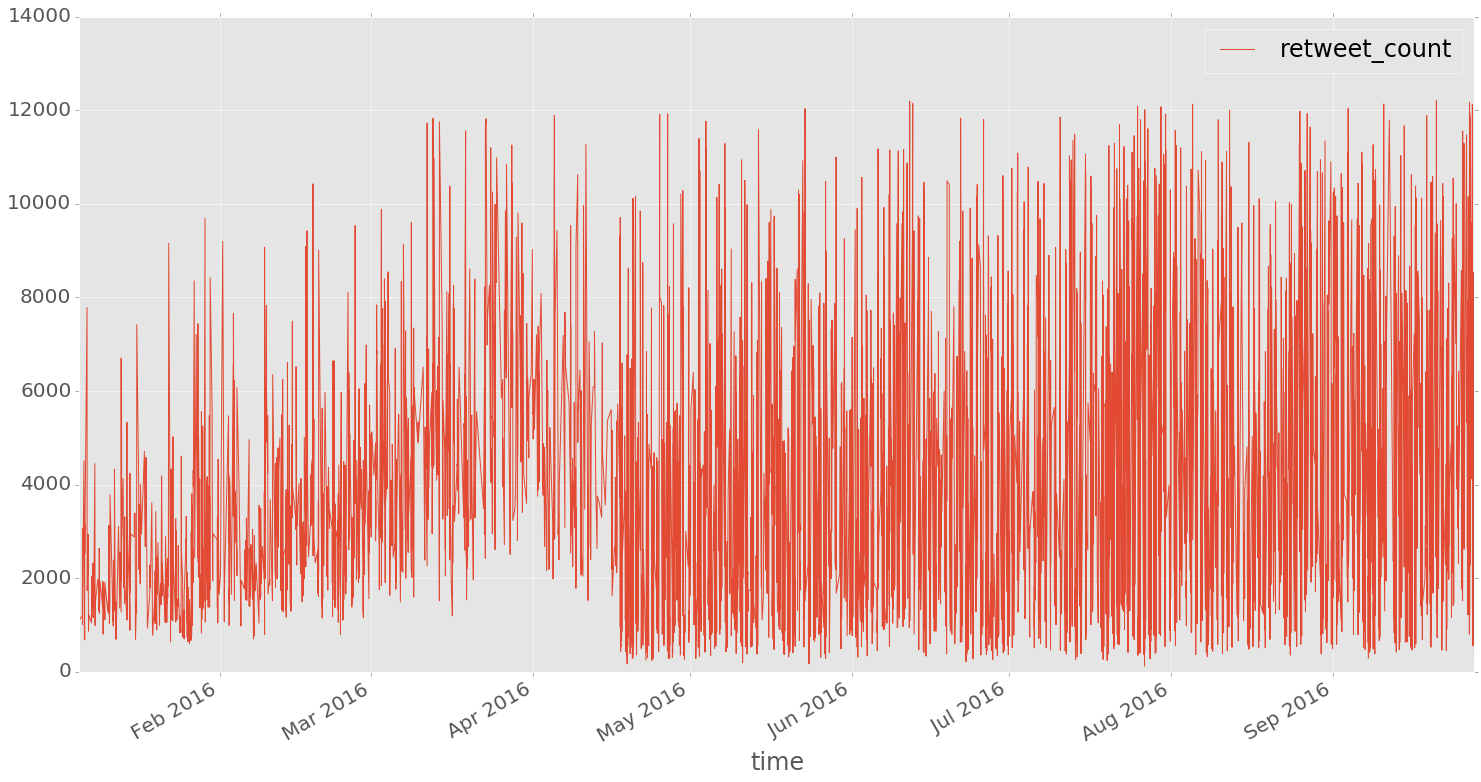

In [10]:
threshold = df.retweet_count.quantile(0.95)
df[df.retweet_count < threshold].plot(x='time', y='retweet_count')

Sokkal egyenletesebb eloszlást kaptunk, úgy tűnik, hogy a retweetek eloszlása lecsengő, tehát sok kisebb érték van és néhány nagyon nagy. Ábrázoljuk hisztogramon.

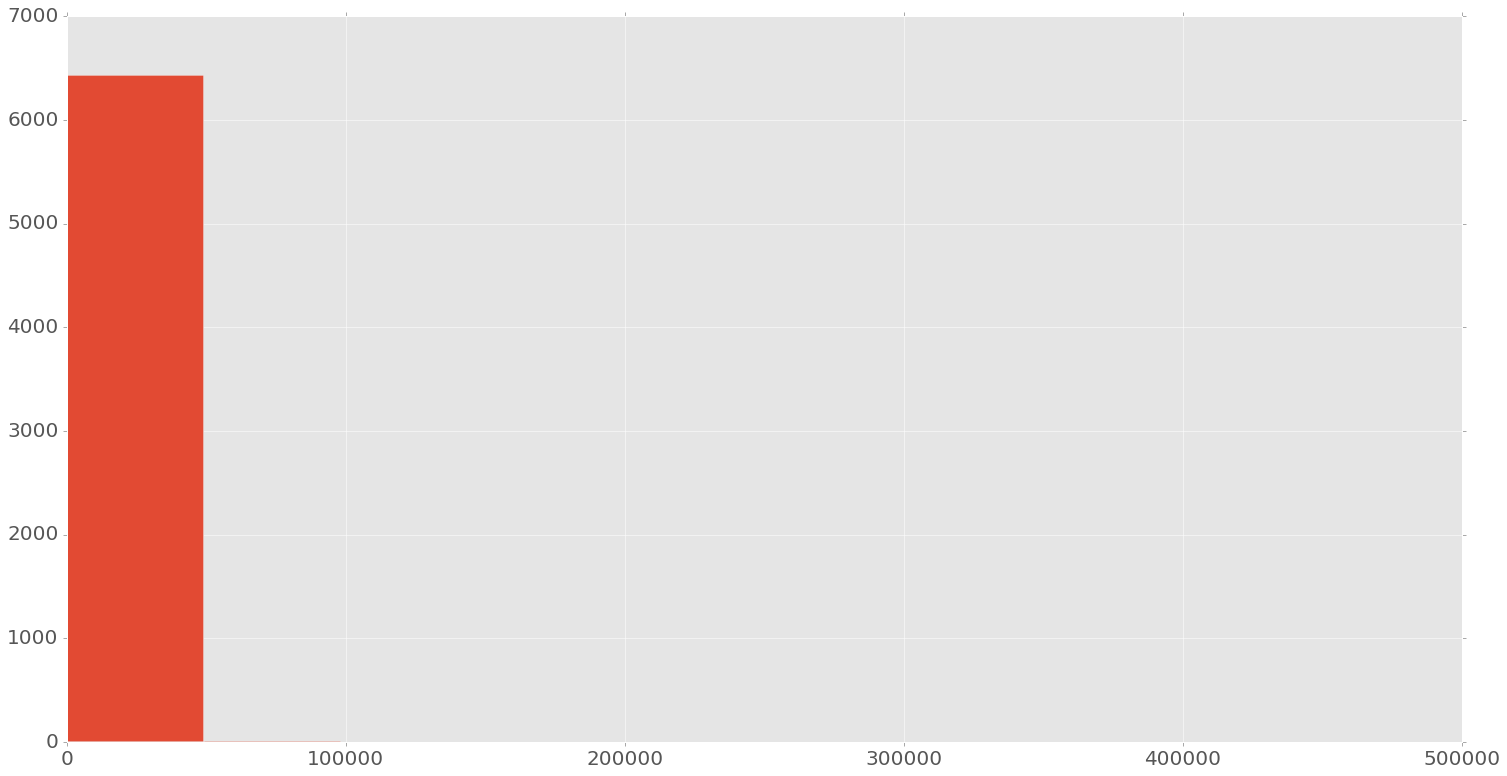

In [11]:
df.retweet_count.hist()

### Melyik tweeteket retweetelték legtöbbször?

Érdemes rákeresni ezekre a tweetekre :)

In [12]:
df.sort_values('retweet_count').tail()

text is_retweet  \
4464  Happy #CincoDeMayo! The best taco bowls are ma...      False   
135   "I never said that." —Donald Trump, who said t...      False   
2530  The media is spending more time doing a forens...      False   
3611  How long did it take your staff of 823 people ...      False   
3616       Delete your account. https://t.co/Oa92sncRQY      False   

     original_author                time  retweet_count  favorite_count  \
4464             NaN 2016-05-05 18:57:30          82653          115107   
135              NaN 2016-09-27 01:19:47          91670          134808   
2530             NaN 2016-07-20 15:36:06         120817          247883   
3611             NaN 2016-06-09 20:40:32         167274          294162   
3616             NaN 2016-06-09 18:27:53         490180          660384   

               handle   author  
4464  realDonaldTrump    Trump  
135    HillaryClinton  Clinton  
2530  realDonaldTrump    Trump  
3611  realDonaldTrump    Trump  
3616   HillaryClinton  Clinton

### Mi a helyzet a favorite_counttal?

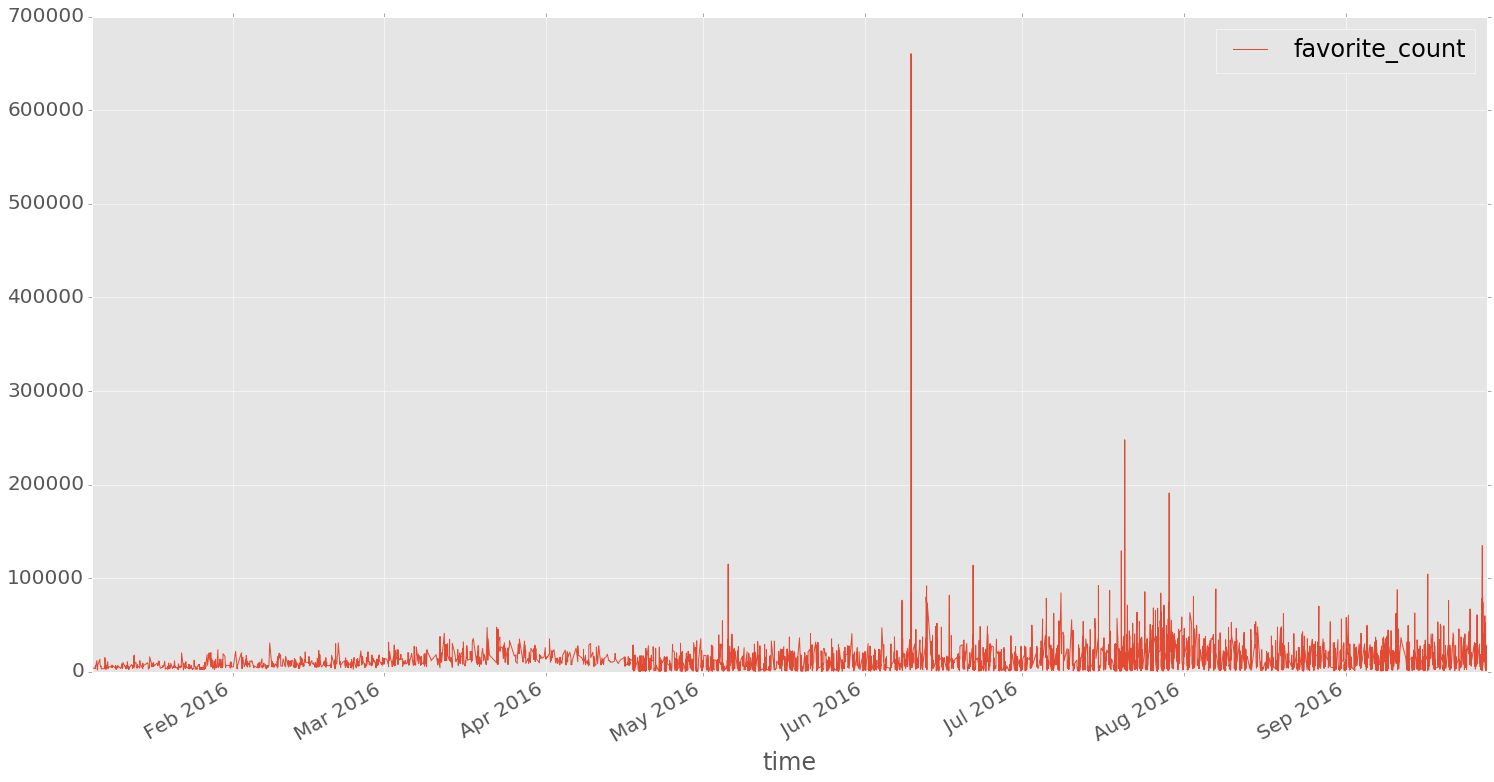

In [13]:
df.plot(x='time', y=['author', 'favorite_count'])

Első ránézésre nem igazán tér el a retweet_count-tól. Mentsük a kettő különbségét egy új oszlopba:

In [14]:
df['r_minus_f'] = df.retweet_count - df.favorite_count

In [15]:
df.r_minus_f.describe()

count      6444.000000
mean      -7254.503724
std        8031.012313
min     -170204.000000
25%       -9746.750000
50%       -4630.500000
75%       -2263.500000
max       12722.000000
Name: r_minus_f, dtype: float64

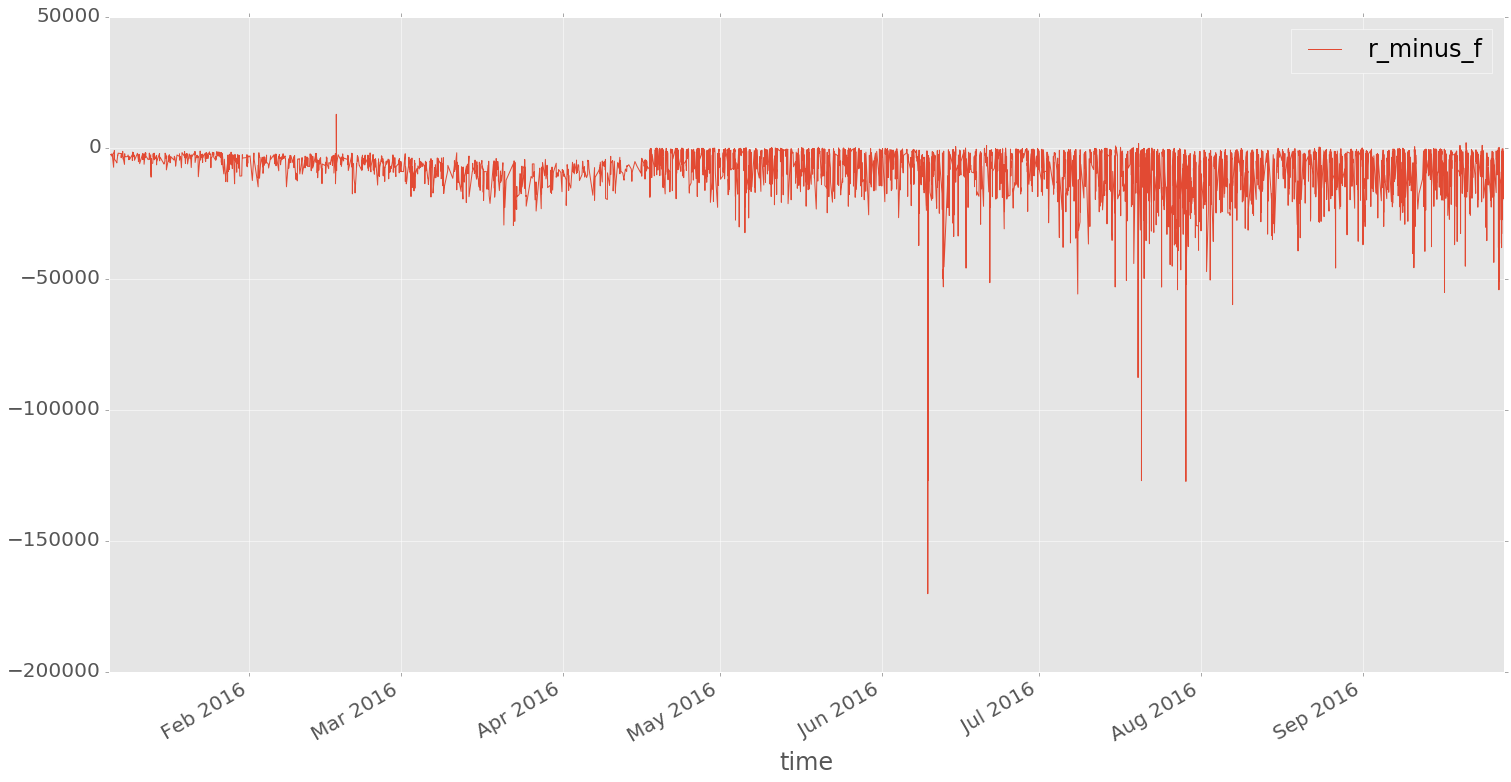

In [16]:
df.plot(x='time', y='r_minus_f')

Ahol a legnagyobb a különbség:

In [17]:
df.sort_values(by='r_minus_f').head()

text is_retweet  \
3616       Delete your account. https://t.co/Oa92sncRQY      False   
1855  Great speech. She's tested. She's ready. She n...       True   
2530  The media is spending more time doing a forens...      False   
3611  How long did it take your staff of 823 people ...      False   
2554  Such a great honor to be the Republican Nomine...      False   

     original_author                time  retweet_count  favorite_count  \
3616             NaN 2016-06-09 18:27:53         490180          660384   
1855           POTUS 2016-07-29 03:34:27          63628          190992   
2530             NaN 2016-07-20 15:36:06         120817          247883   
3611             NaN 2016-06-09 20:40:32         167274          294162   
2554             NaN 2016-07-19 23:52:59          41461          129198   

               handle   author  r_minus_f  
3616   HillaryClinton  Clinton    -170204  
1855   HillaryClinton  Clinton    -127364  
2530  realDonaldTrump    Trump    -127066  
3611  realDonaldTrump    Trump    -126888  
2554  realDonaldTrump    Trump     -87737

### Szorgalmi: vizsgáld meg a két mennyiség arányát! 

## Szövegek elemzése

Térjünk rá a tweetek szövegeinek elemzésére. Ehhez két segédfüggvényt hozunk létre: az egyik tokenizálja (szavakra bontja) és szűri a szöveget, a másik szófelhőt rajzol.

In [18]:
def filter_and_tokenize(text):
    from string import punctuation
    stopwords = nltk.corpus.stopwords.words('english')
    blacklist = {
        "...", "—", "'s", "''", "—hillary", "hillaryclinton", 
        "http", "https", "amp",
        "trump", "trump2016", "donald", "clinton", "hillary", 
        "realdonaldtrump", "let", "go"
    }
    out_tokens = []
    for token in nltk.tokenize.word_tokenize(text):
        token = token.lower()
        if token not in punctuation and token not in stopwords and token not in blacklist:
            out_tokens.append(token)
    return out_tokens



def draw_wordcloud(text):
    tokens = filter_and_tokenize(text)
    text = " ".join(tokens)
    wordcloud_hc = WordCloud(max_font_size=40, stopwords=STOPWORDS, background_color='white').generate(text)
    plt.figure()
    plt.imshow(wordcloud_hc)
    plt.axis("off")
    plt.show()

### Alapvető szövegstatisztikák

A %%time magic utasítással számoljuk meddig tart a cella futása.

In [19]:
%%time
df['char_count'] = df.text.str.len()
df['tokens'] = df.text.apply(filter_and_tokenize)
df['types'] = df.tokens.apply(set)
df['type_count'] = df.types.apply(len)
df['token_count'] = df.tokens.apply(len)
df['ttr'] = df.type_count / df.token_count

CPU times: user 5.45 s, sys: 120 ms, total: 5.57 s
Wall time: 5.58 s


A két jelöltre összegezve:

In [20]:
df[['token_count', 'char_count', 'type_count', 'author']].groupby('author').sum()

token_count  char_count  type_count
author                                      
Clinton        33368      382318       32609
Trump          32598      366003       32012

A két jelöltre átlagolva (amit van értelme átlagolni):

In [21]:
df[['token_count', 'char_count', 'type_count', 'ttr', 'author']].groupby('author').mean()

token_count  char_count  type_count       ttr
author                                                
Clinton    10.343459  118.511469   10.108184  0.980441
Trump      10.129894  113.736172    9.947794  0.985517

### Hogy oszlik el a tweetek hosszúsága a jelöltek közt?

A szavak számáról készítünk hisztogramot.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efc09e91f60>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7efc09c9fd30>], dtype=object)

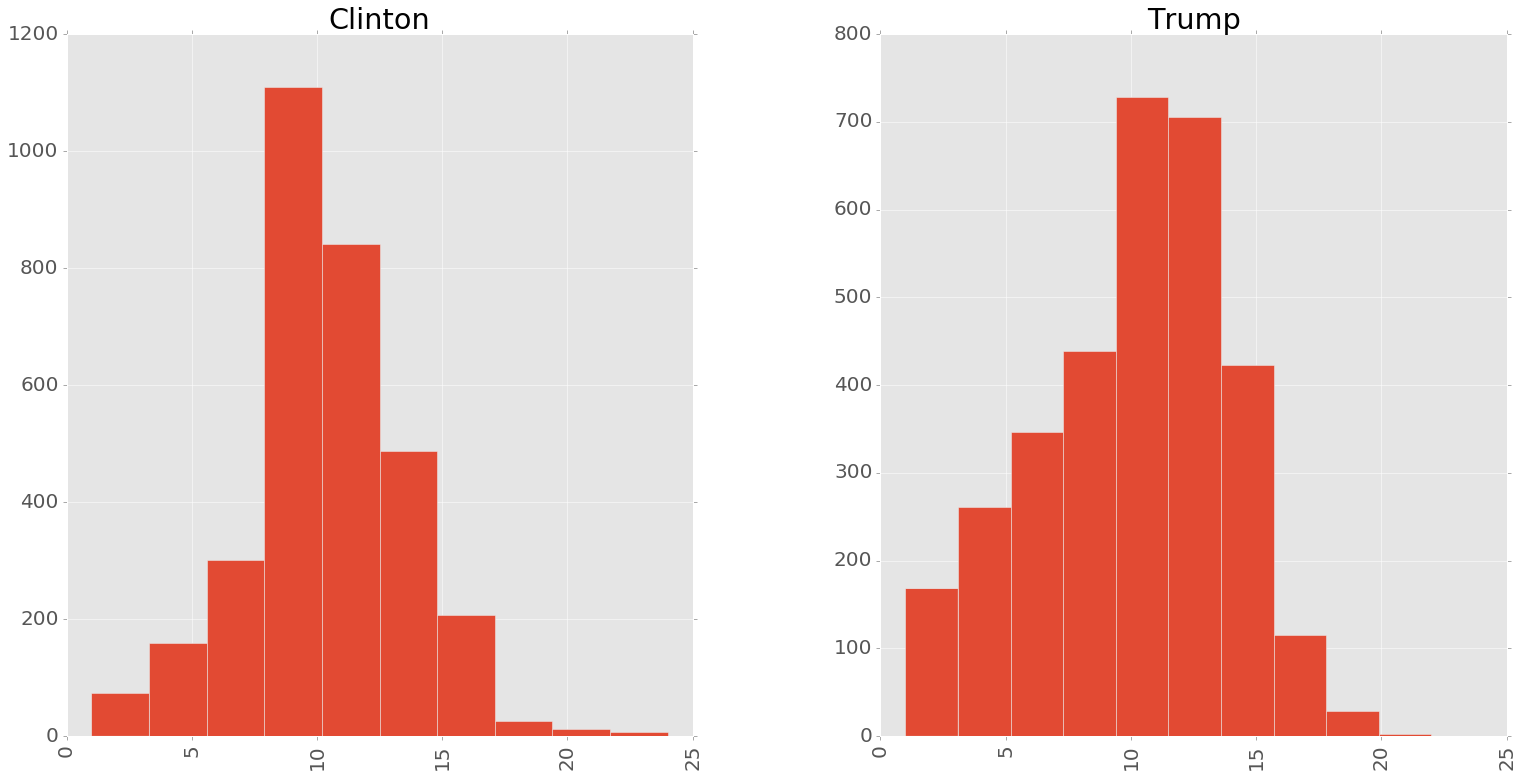

In [22]:
df[['token_count', 'author']].hist(by='author', sharex=True)

Az átlag ugyan majdnem ugyanaz a két jelölt közt, de Trumpnál jóval nagyobb arányban fordulnak elő a 10 szónál hosszabb tweetek.

### Szógyakoriságok vizsgálata 

In [23]:
clinton_tokens = filter_and_tokenize(df[df.author=="Clinton"].text.str.cat())
trump_tokens = filter_and_tokenize(df[df.author=="Trump"].text.str.cat())

A két jelölt "szókincse":

In [24]:
len(set(clinton_tokens)), len(set(trump_tokens))

(9515, 8430)

### Milyen szavakat használnak szívesen? 

In [25]:
from collections import Counter
clinton_counter = Counter(clinton_tokens)
trump_counter = Counter(trump_tokens)
diff = {k: clinton_counter.get(k, 0)-trump_counter.get(k, 0) for k in set(clinton_counter.keys()) | set(trump_counter.keys())}

In [26]:
s = sorted(diff.items(), key=lambda x: abs(x[1]), reverse=True)

#### A legnagyobb abszolút eltérést az alábbi szavaknál találjuk

In [27]:
topn = 30
for word, freqdiff in s[:topn]:
    print("{0} --\t {1} --\t Clinton:{2} vs. Trump:{3}".format(word, "Clinton" if freqdiff > 0 else "Trump",
                                          clinton_counter.get(word, 0), trump_counter.get(word, 0)))

great --	 Trump --	 Clinton:62 vs. Trump:424
makeamericagreatagain --	 Trump --	 Clinton:0 vs. Trump:242
thank --	 Trump --	 Clinton:22 vs. Trump:259
`` --	 Trump --	 Clinton:300 vs. Trump:523
cruz --	 Trump --	 Clinton:5 vs. Trump:192
crooked --	 Trump --	 Clinton:0 vs. Trump:158
president --	 Clinton --	 Clinton:255 vs. Trump:105
families --	 Clinton --	 Clinton:129 vs. Trump:13
potus --	 Clinton --	 Clinton:130 vs. Trump:17
ted --	 Trump --	 Clinton:5 vs. Trump:116
need --	 Clinton --	 Clinton:129 vs. Trump:27
big --	 Trump --	 Clinton:30 vs. Trump:131
us --	 Clinton --	 Clinton:163 vs. Trump:64
cnn --	 Trump --	 Clinton:2 vs. Trump:99
americans --	 Clinton --	 Clinton:117 vs. Trump:22
new --	 Trump --	 Clinton:83 vs. Trump:177
poll --	 Trump --	 Clinton:0 vs. Trump:88
enjoy --	 Trump --	 Clinton:2 vs. Trump:87
plan --	 Clinton --	 Clinton:88 vs. Trump:4
foxnews --	 Trump --	 Clinton:0 vs. Trump:83
tonight --	 Trump --	 Clinton:29 vs. Trump:111
media --	 Trump --	 Clinton:1 vs. Trum

### Milyen arányban hasznáják a leggyakoribb szavakat?

Megnézzük, hogy a 200 leggyakoribb szó (a korpusz alapján) milyen arányban fordul elő az egyes tweetekben.

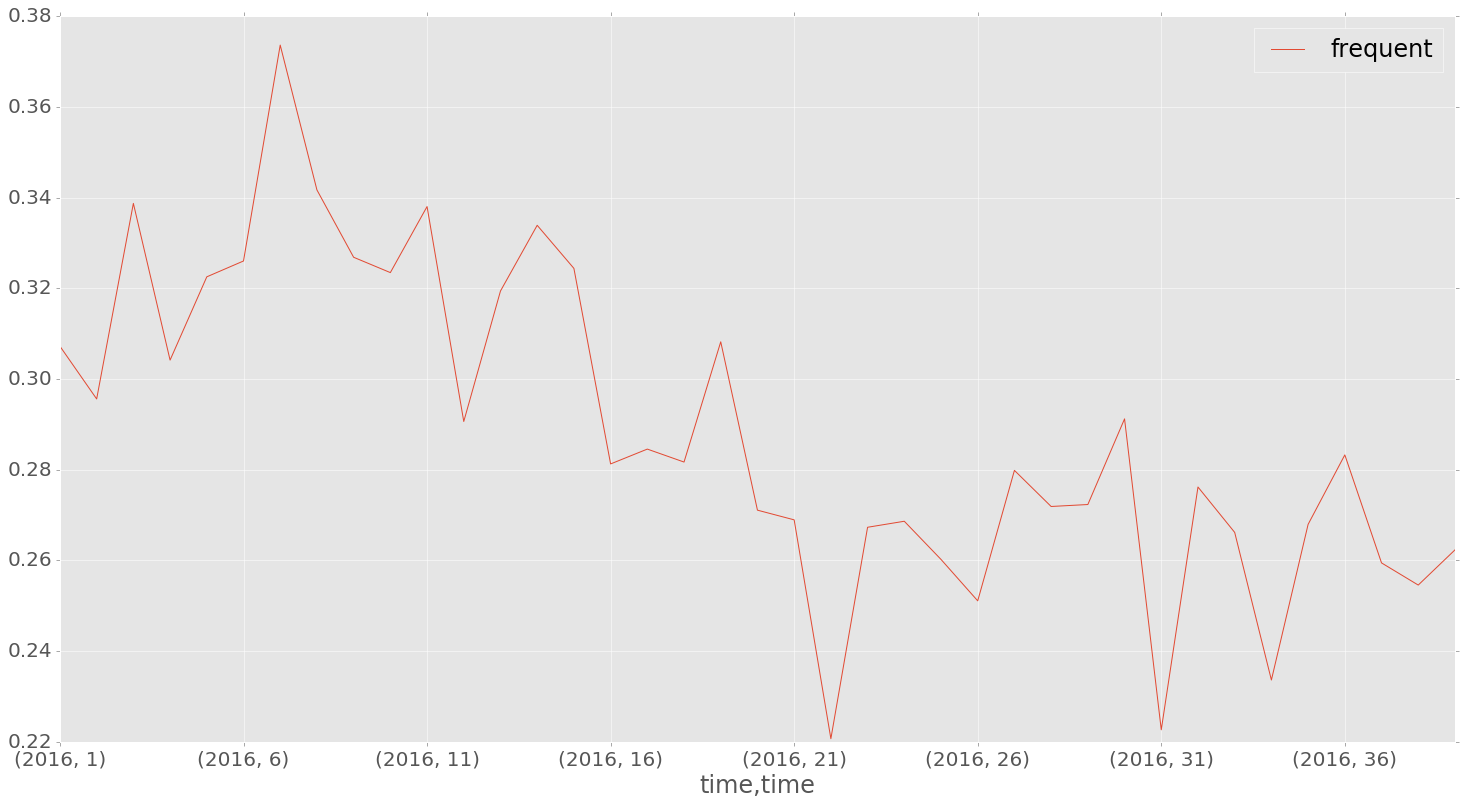

In [28]:
top200 = set(w[0] for w in s[:200])
df['frequent'] = df.tokens.apply(lambda x: len(list(filter(lambda y: y in top200, x))) / len(x))
df.groupby(by=[df.time.dt.year, df.time.dt.week]).mean().plot(y='frequent')

#### Jelöltekre bontva ugyanezt

Azt tapasztaljuk, hogy Trump nagyobb részben használja a leggyakoribb szavakat, mint Clinton.

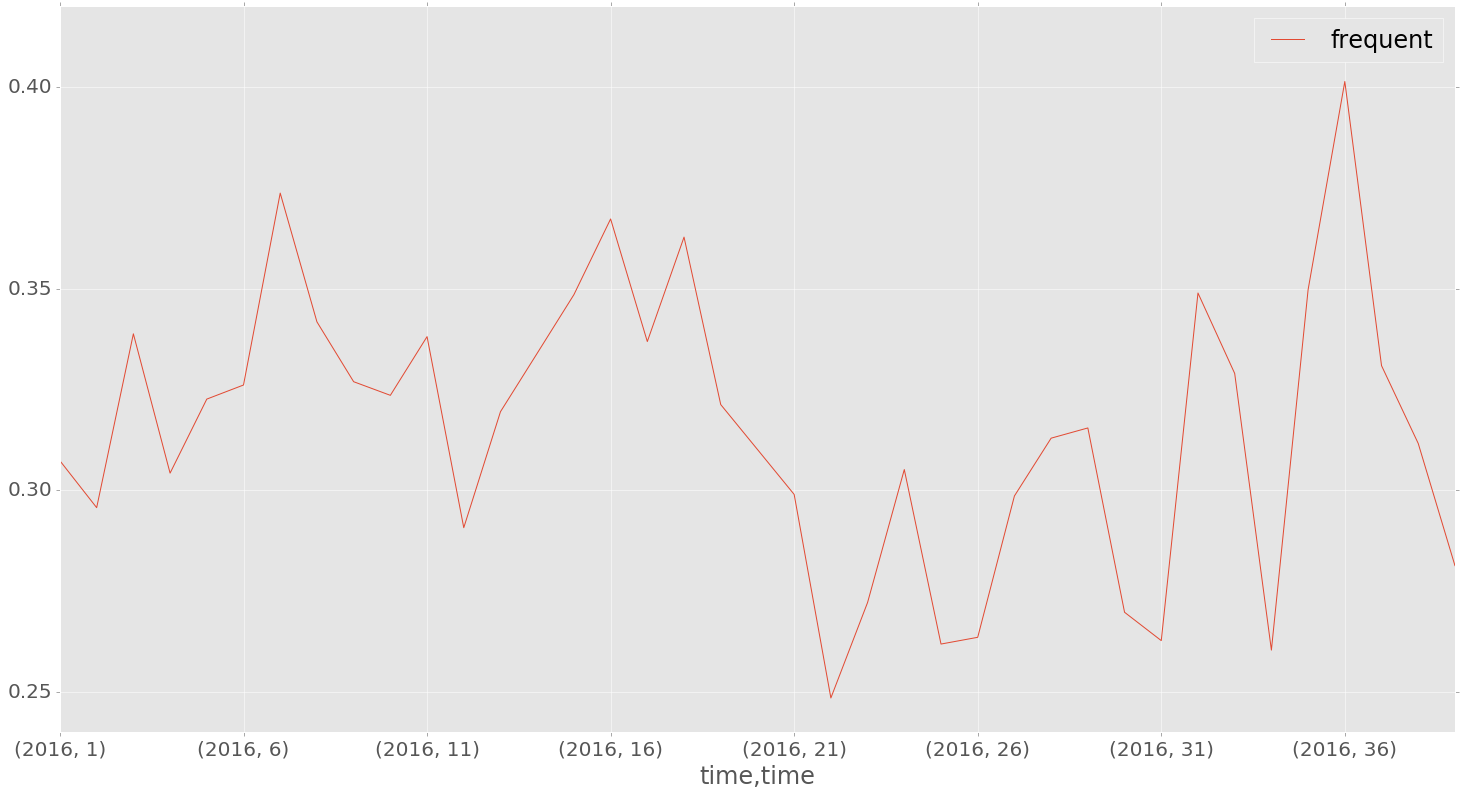

In [29]:
top200 = set(w[0] for w in s[:200])
df['frequent'] = df.tokens.apply(lambda x: len(list(filter(lambda y: y in top200, x))) / len(x))
df[df.author=="Trump"].groupby(by=[df.time.dt.year, df.time.dt.week]).mean().plot(y='frequent')

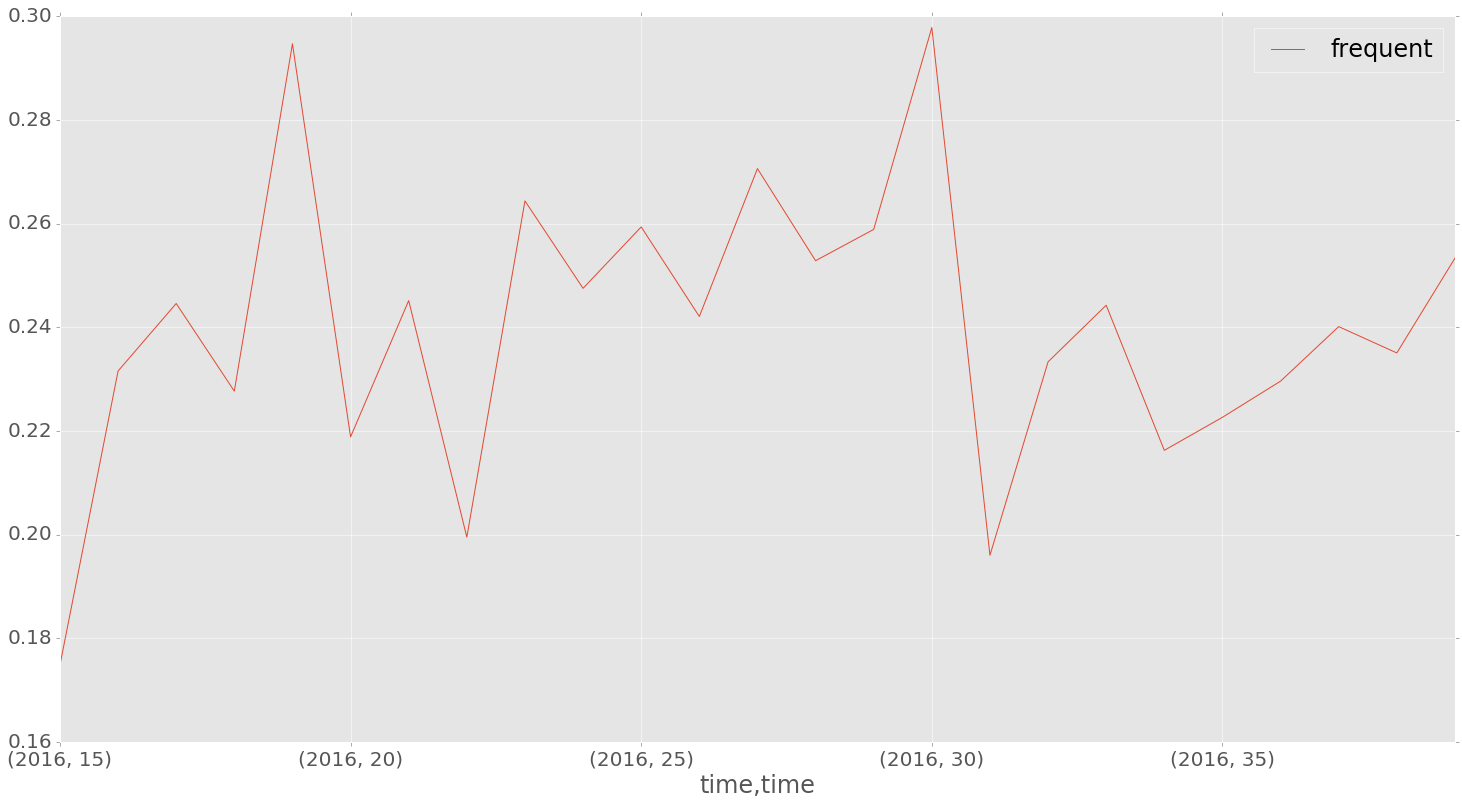

In [30]:
top200 = set(w[0] for w in s[:200])
df['frequent'] = df.tokens.apply(lambda x: len(list(filter(lambda y: y in top200, x))) / len(x))
df[df.author=="Clinton"].groupby(by=[df.time.dt.year, df.time.dt.week]).mean().plot(y='frequent')

## És végül készítsünk szófelhőket 

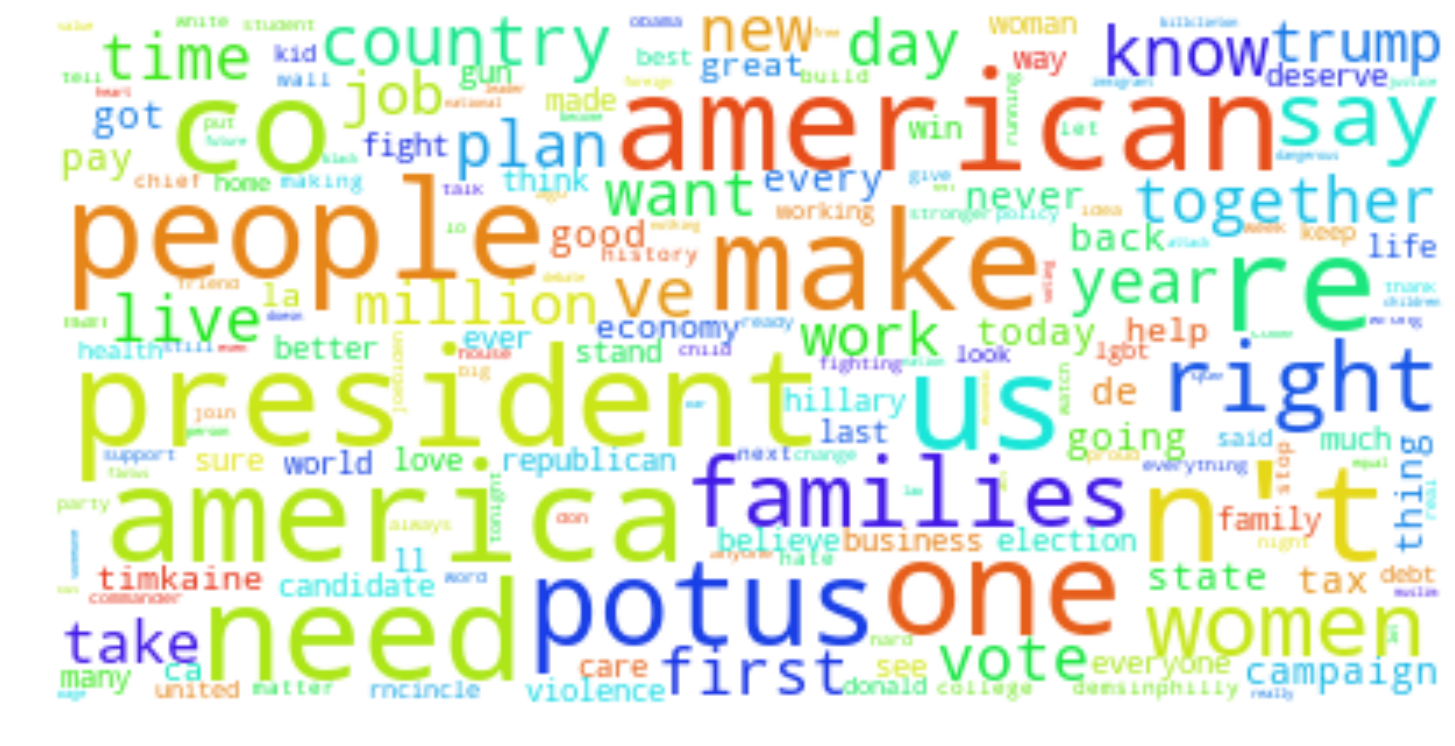

In [31]:
t = df[df.author=="Clinton"]['text'].str.cat().lower()
draw_wordcloud(t)

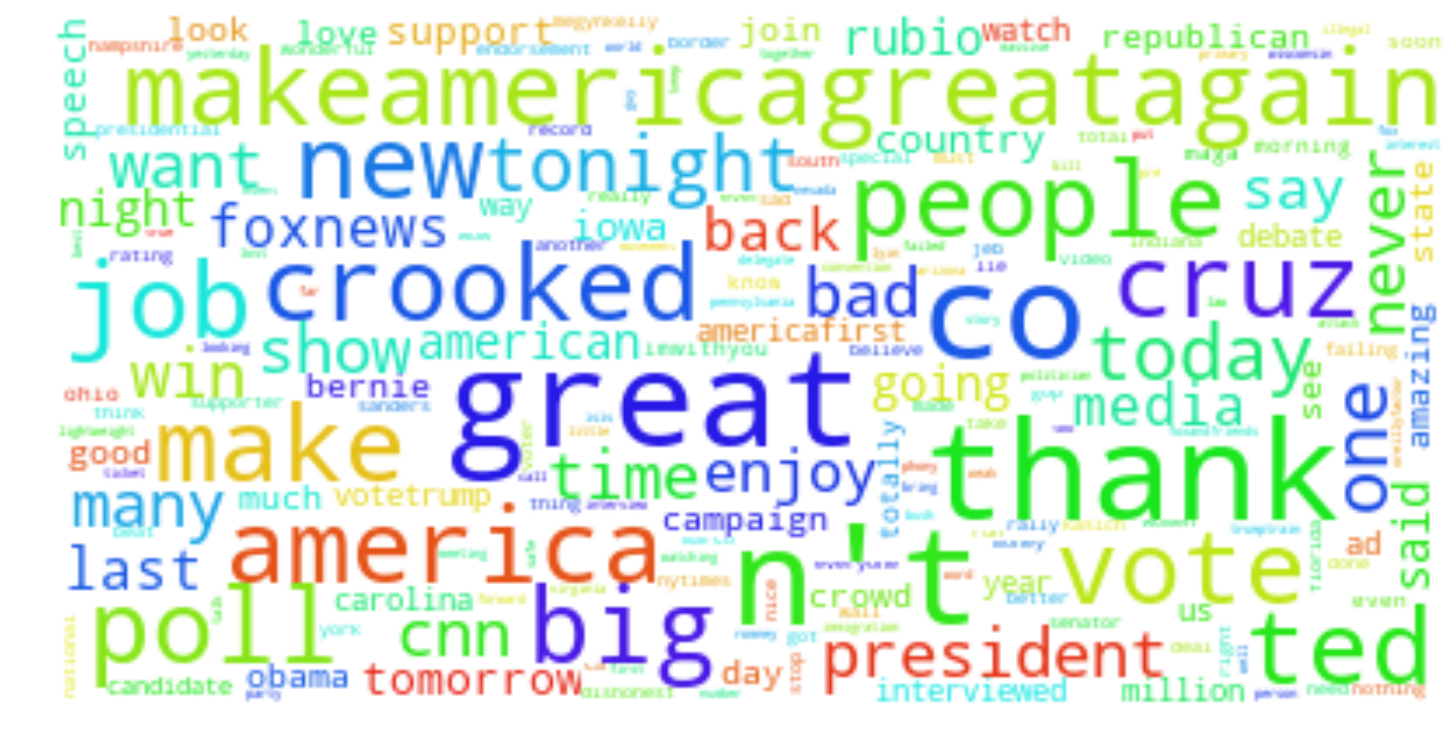

In [32]:
t = df[df.author=="Trump"]['text'].str.cat().lower()
draw_wordcloud(t)

# Legnépszerűbb tweetek szófelhői 

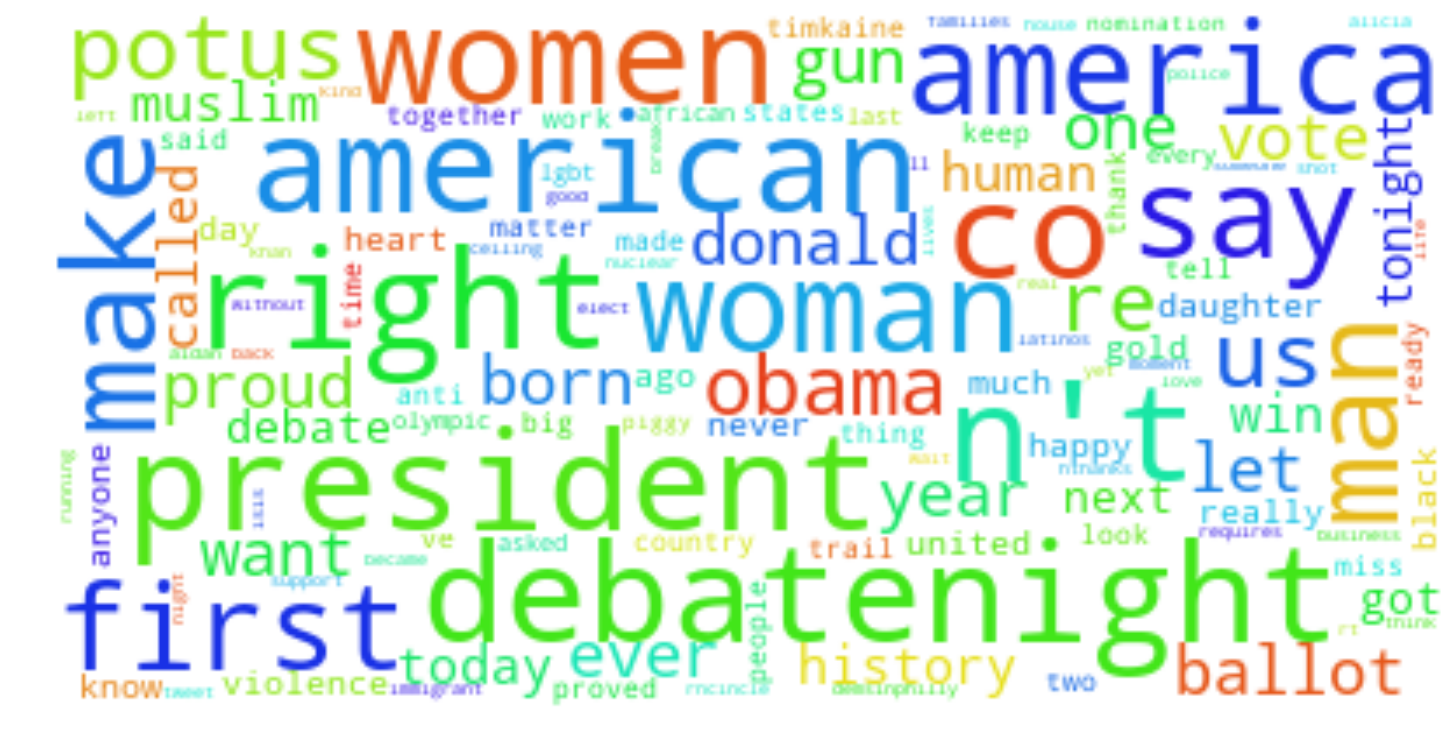

In [33]:
d = df[df.author=="Clinton"]
th = d.favorite_count.quantile(.95)
draw_wordcloud(d[d.favorite_count>th].text.str.cat())

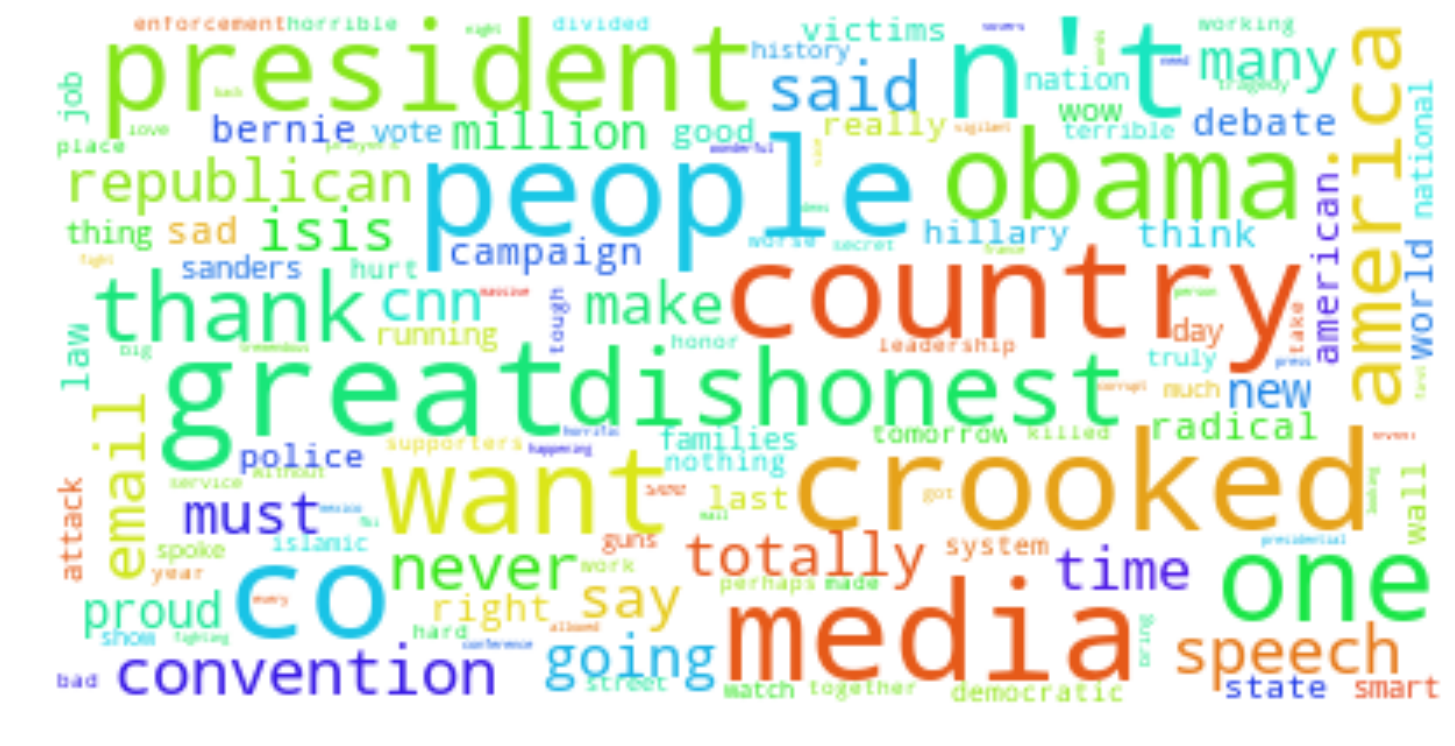

In [34]:
d = df[df.author=="Trump"]
th = d.favorite_count.quantile(.95)
draw_wordcloud(d[d.favorite_count>th].text.str.cat())